In [ ]:
import zipfile
import cv2
import dlib
import os

# 이미지가 포함된 폴더 경로
image_folder = '/content/drive/MyDrive/Image_Dataset/Train'

# 이미지 분류 코드
output_folder = '/content/drive/MyDrive/Image_Dataset/DetectionFace_Train/sadness'

# 폴더가 없다면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 얼굴 검출기 초기화
face_detector = dlib.get_frontal_face_detector()

# 압축 파일 경로
zip_filename = 'sadness.zip'
zip_path = os.path.join(image_folder, zip_filename)

# 폴더 생성
emotion_folder = os.path.join(output_folder, 'sadness')
if not os.path.exists(emotion_folder):
    os.makedirs(emotion_folder)

# 압축 파일 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(emotion_folder)

# 이미지 처리
count = 825
for root, _, files in os.walk(emotion_folder):
    for file in files:
        image_path = os.path.join(root, file)

        # 이미지 파일 확인
        if not os.path.isfile(image_path):
            print(f"{image_path}은(는) 파일이 아닙니다.")
            continue

        # 이미지 읽기
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"{image_path}을(를) 읽을 수 없습니다.")
                continue
        except Exception as e:
            print(f"{image_path}을(를) 읽을 때 예외가 발생했습니다: {str(e)}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 얼굴 검출
        faces = face_detector(gray)

        # 얼굴이 인식되지 않은 경우 건너뛰기
        if len(faces) == 0:
            print(f"{image_path}에서 얼굴을 찾을 수 없습니다.")
            continue

        # 이미지에서 얼굴 영역만 추출하여 저장
        for face in faces:
            # 얼굴 영역의 좌표 계산
            x1 = face.left()
            y1 = face.top()
            x2 = face.right()
            y2 = face.bottom()

            # 이미지 크기 확인
            face_width = x2 - x1
            face_height = y2 - y1
            min_face_size = 30  # 최소 얼굴 크기 설정
            if face_width < min_face_size or face_height < min_face_size:
                print(f"{image_path}에서 얼굴 크기가 너무 작습니다.")
                continue

            # 얼굴 영역 이미지 추출
            face_img = img[y1:y2, x1:x2]

            # 저장할 파일명 설정 (숫자로 저장)
            filename = f'{count}.jpg'
            count += 1

            # 저장할 경로 설정
            output_path = os.path.join(emotion_folder, filename)

            # 얼굴 영역 이미지 저장
            try:
                cv2.imwrite(output_path, face_img)
            except Exception as e:
                print(f"{output_path}에 이미지를 저장할 때 예외가 발생했습니다: {str(e)}")

print("얼굴 영역 저장 완료!")

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import dlib
import os
from sklearn.model_selection import train_test_split

# 이미지 크기
width, height = 48, 48

# 이미지 데이터셋 디렉토리 경로
train_dataset_dir = '/content/drive/MyDrive/Image_Dataset/DetectionFace_Train'

# 감정 레이블
emotion_labels = ['anger', 'anxiety', 'happiness', 'neutral', 'sadness']

# 데이터 증강을 포함한 이미지 데이터셋 불러오기 및 전처리
def load_dataset(dataset_dir):
    data = []
    labels = []

    for emotion_idx, emotion in enumerate(os.listdir(dataset_dir)):
        emotion_dir = os.path.join(dataset_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue

        for img_name in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_name)
            img = cv2.imread(img_path)

            resized_img = cv2.resize(img, (width, height))
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            normalized_img = gray_img / 255.0

            normalized_img = tf.expand_dims(normalized_img, axis=-1)
            data.append(normalized_img)
            labels.append(emotion_idx)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [ ]:
# Train 데이터셋 로드
train_data, train_labels = load_dataset(train_dataset_dir)

In [ ]:
# Train 데이터셋을 Train과 Validation으로 분할 (Train: 80%, Validation: 20%)
train_data, validation_data, train_labels, validation_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42)

print("Train 데이터셋 shape:", train_data.shape)
print("Validation 데이터셋 shape:", validation_data.shape)

Train 데이터셋 shape: (6968, 48, 48, 1)
Validation 데이터셋 shape: (1742, 48, 48, 1)


In [ ]:
# 모델 설계
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((width, height, 1), input_shape=(width, height)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(emotion_labels), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping과 ModelCheckpoint 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Image_Dataset/best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# 모델 학습
h = model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(validation_data, validation_labels), callbacks=[early_stopping, checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


218/218 [==============================] - ETA: 0s - loss: 1.6077 - accuracy: 0.2210
Epoch 1: val_loss improved from inf to 1.60424, saving model to /content/drive/MyDrive/Image_Dataset/best_model.h5
218/218 [==============================] - 16s 15ms/step - loss: 1.6077 - accuracy: 0.2210 - val_loss: 1.6042 - val_accuracy: 0.2325
Epoch 2/50
212/218 [============================>.] - ETA: 0s - loss: 1.4788 - accuracy: 0.3255
Epoch 2: val_loss improved from 1.60424 to 1.30498, saving model to /content/drive/MyDrive/Image_Dataset/best_model.h5
218/218 [==============================] - 2s 7ms/step - loss: 1.4762 - accuracy: 0.3265 - val_loss: 1.3050 - val_accuracy: 0.4259
Epoch 3/50
216/218 [============================>.] - ETA: 0s - loss: 1.2926 - accuracy: 0.4129
Epoch 3: val_loss improved from 1.30498 to 1.22074, saving model to /content/drive/MyDrive/Image_Dataset/best_model.h5
218/218 [==============================] - 2s 7ms/step - loss: 1.2920 - accuracy: 0.4130 - val_loss: 1.220

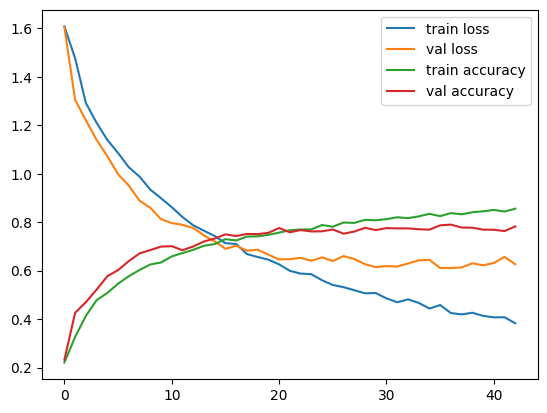

In [ ]:
# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [ ]:
import dlib

# dlib 얼굴 검출기 초기화
face_detector = dlib.get_frontal_face_detector()

# 사용자 이미지 테스트
def classify_emotion(image_path):
    # 이미지 불러오기 및 전처리
    image = cv2.imread(image_path)

    def extract_face(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 얼굴 검출
        faces = face_detector(gray)

        # 얼굴이 인식되지 않은 경우 None 반환
        if len(faces) == 0:
            return None

        # 첫 번째 얼굴 영역 추출
        face = faces[0]

        # 얼굴 영역의 좌표 계산
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        # 얼굴 영역 이미지 추출
        face_img = gray[y1:y2, x1:x2]

        return face_img

    # 이미지 전처리
    face_img = extract_face(image)  # face_img 변수 정의
    if face_img is None:
        return {}

    resized_image = cv2.resize(face_img, (width, height))
    normalized_image = resized_image / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)
    input_image = np.expand_dims(input_image, axis=3)

    # 감정 분류 예측
    predictions = model.predict(input_image)

    # 각 클래스에 대한 확률 계산
    probabilities = predictions[0] * 100 / np.sum(predictions[0])

    # 감정별 확률 딕셔너리 생성
    emotion_probabilities = {}
    for i, emotion in enumerate(emotion_labels):
        emotion_probabilities[emotion] = probabilities[i]

    return emotion_probabilities

In [ ]:
# 사용자 이미지 경로
user_image_path = '/content/drive/MyDrive/Image_Dataset/face.jpg'

predicted_emotion_probabilities = classify_emotion(user_image_path)
for emotion, probability in predicted_emotion_probabilities.items():
    print(f'감정: {emotion}, 확률: {probability:.2f}%')

1/1 [==============================] - 0s 28ms/step
감정: anger, 확률: 0.02%
감정: anxiety, 확률: 0.12%
감정: happiness, 확률: 99.73%
감정: neutral, 확률: 0.12%
감정: sadness, 확률: 0.02%
